In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [2]:
df =  pd.read_csv("D:\dl\creditcard.csv")

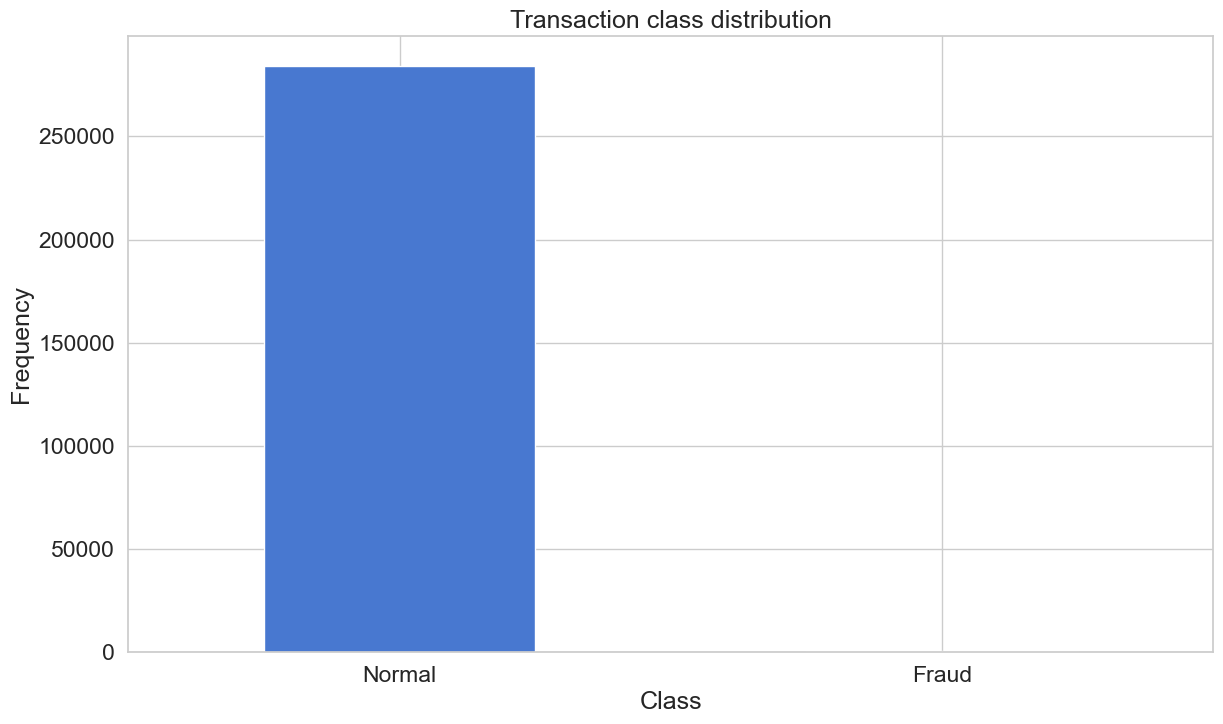

In [3]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

In [4]:
from sklearn.preprocessing import StandardScaler

data = df.drop(['Time'], axis=1)

data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))


In [5]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

In [6]:
input_dim = X_train.shape[1]
encoding_dim = 14

In [7]:
input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

In [8]:

nb_epoch = 100
batch_size = 32
early_stop = tf.keras.callbacks. EarlyStopping( monitor= 'val_loss', min_delta=0.0001, patience=10, verbose=1, mode='min', 
                                               restore_best_weights=True)

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, early_stop]).history

Epoch 1/100
7108/7108 [==============================] - 20s 3ms/step - loss: 0.8001 - accuracy: 0.6080 - val_loss: 0.7816 - val_accuracy: 0.6726
Epoch 2/100
  22/7108 [..............................] - ETA: 21s - loss: 0.9069 - accuracy: 0.6832 

C:\Users\rugve\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7108/7108 [==============================] - 19s 3ms/step - loss: 0.7372 - accuracy: 0.6777 - val_loss: 0.7610 - val_accuracy: 0.6889
Epoch 3/100
7108/7108 [==============================] - 19s 3ms/step - loss: 0.7243 - accuracy: 0.6935 - val_loss: 0.7522 - val_accuracy: 0.6963
Epoch 4/100
7108/7108 [==============================] - 18s 3ms/step - loss: 0.7175 - accuracy: 0.7052 - val_loss: 0.7469 - val_accuracy: 0.7140
Epoch 5/100
7108/7108 [==============================] - 19s 3ms/step - loss: 0.7132 - accuracy: 0.7120 - val_loss: 0.7447 - val_accuracy: 0.7167
Epoch 6/100
7108/7108 [==============================] - 18s 3ms/step - loss: 0.7105 - accuracy: 0.7184 - val_loss: 0.7450 - val_accuracy: 0.7124
Epoch 7/100
7108/7108 [==============================] - 19s 3ms/step - loss: 0.7086 - accuracy: 0.7232 - val_loss: 0.7428 - val_accuracy: 0.7201
Epoch 8/100
7108/7108 [==============================] - 19s 3ms/step - loss: 0.7075 - accuracy: 0.7254 - val_loss: 0.7426 - val_accurac

Epoch 58/100
7108/7108 [==============================] - 18s 2ms/step - loss: 0.6966 - accuracy: 0.7428 - val_loss: 0.7313 - val_accuracy: 0.7458
Epoch 59/100
7108/7108 [==============================] - 18s 3ms/step - loss: 0.6965 - accuracy: 0.7420 - val_loss: 0.7311 - val_accuracy: 0.7450
Epoch 60/100
7108/7108 [==============================] - 19s 3ms/step - loss: 0.6965 - accuracy: 0.7424 - val_loss: 0.7306 - val_accuracy: 0.7452
Epoch 61/100
7108/7108 [==============================] - 19s 3ms/step - loss: 0.6964 - accuracy: 0.7426 - val_loss: 0.7311 - val_accuracy: 0.7439
Epoch 62/100
7108/7108 [==============================] - 19s 3ms/step - loss: 0.6964 - accuracy: 0.7424 - val_loss: 0.7329 - val_accuracy: 0.7407
Epoch 63/100
7108/7108 [==============================] - 19s 3ms/step - loss: 0.6962 - accuracy: 0.7423 - val_loss: 0.7310 - val_accuracy: 0.7476
Epoch 64/100
7108/7108 [==============================] - 19s 3ms/step - loss: 0.6963 - accuracy: 0.7419 - val_loss: 0

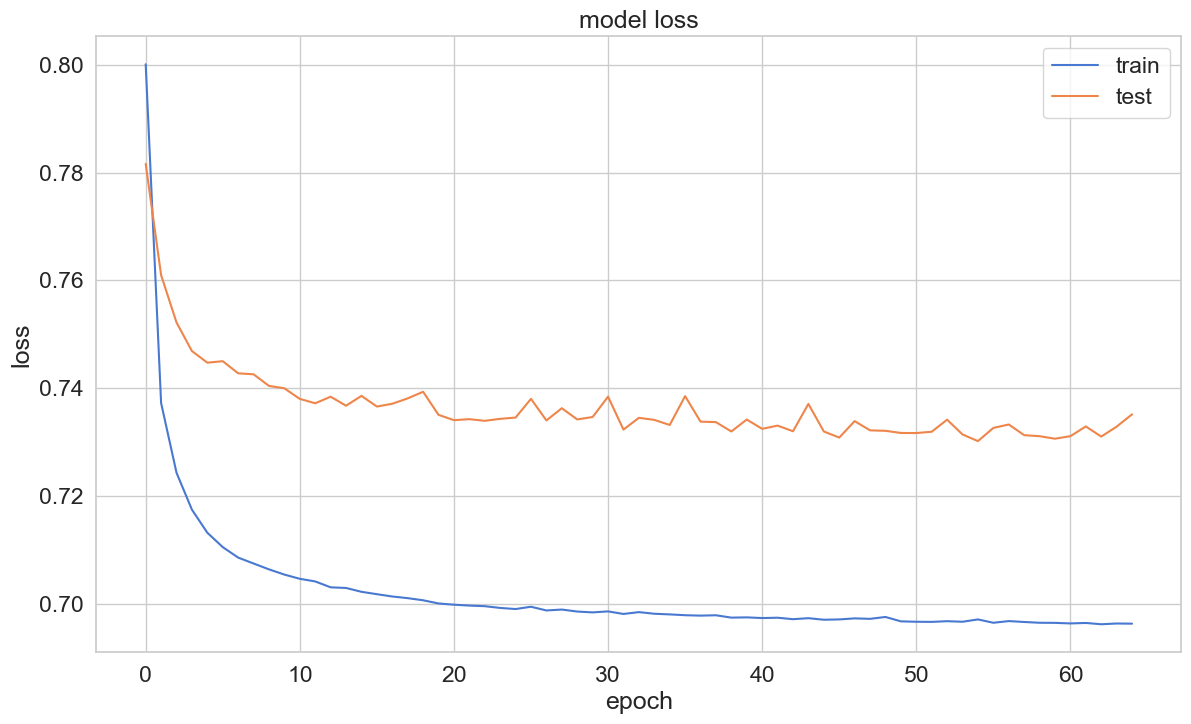

In [9]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [10]:
predictions = autoencoder.predict(X_test)

1781/1781 [==============================] - 4s 2ms/step


In [11]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

In [12]:
error_df.describe()

,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.729266,0.001720
std,3.460286,0.041443
min,0.056343,0.000000
25%,0.249916,0.000000
50%,0.387134,0.000000
75%,0.610408,0.000000
max,292.649360,1.000000


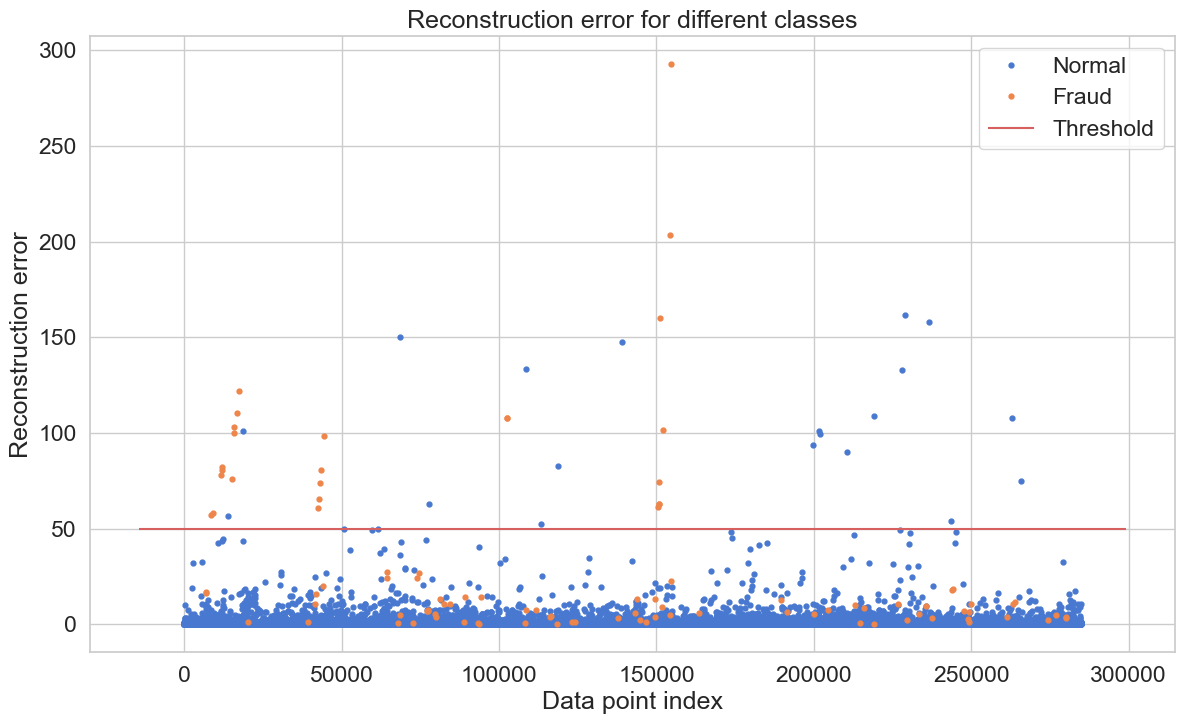

In [13]:
threshold = 50
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [14]:
from sklearn.metrics import confusion_matrix,recall_score,accuracy_score,precision_score

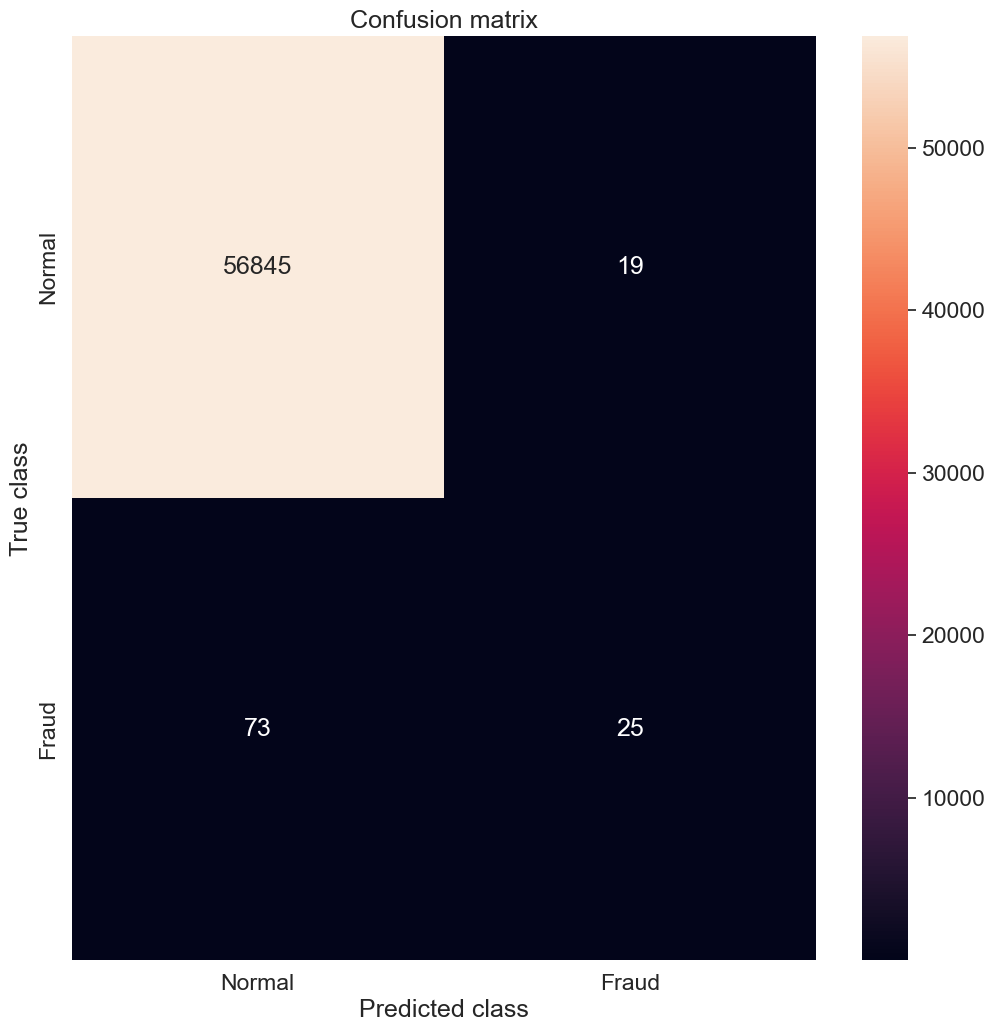

In [15]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [16]:
error_df['pred'] = y_pred

In [17]:
# print Accuracy, precision and recall print(" Accuracy:

print("Accuracy:",accuracy_score (error_df['true_class'],error_df['pred'])) 
print(" Recall:",recall_score(error_df['true_class'],error_df['pred']))
print(" Precision:",precision_score(error_df['true_class'],error_df['pred']))

Accuracy: 0.9983848881710614
 Recall: 0.25510204081632654
 Precision: 0.5681818181818182


Here are the important definitions from the assignment:

1. **Autoencoder**: A type of neural network used for unsupervised learning, designed to compress data into a lower-dimensional representation (latent space) through an **Encoder** and then reconstruct it back to the original input using a **Decoder**.

2. **Encoder**: The part of an autoencoder that compresses the input data into a latent representation (lower-dimensional space).

3. **Decoder**: The part of the autoencoder that reconstructs the original input data from the latent representation.

4. **Reconstruction Error**: The difference between the original input and its reconstructed version. In anomaly detection, data points with high reconstruction errors are flagged as anomalies.

5. **Anomaly Detection**: The process of identifying rare or unusual data points that deviate significantly from the majority of the data, often using machine learning algorithms like autoencoders.

6. **Latent Representation**: The compressed, lower-dimensional encoding of the input data produced by the encoder part of the autoencoder.

7. **Threshold**: A specific value set for the reconstruction error, above which data points are considered anomalies.

8. **StandardScaler**: A preprocessing technique used to scale the data so that each feature has a mean of 0 and a standard deviation of 1, improving the performance of many machine learning models.

9. **Precision**: The fraction of true positive predictions (correctly identified anomalies) out of all positive predictions made by the model.

10. **Recall**: The fraction of true positive predictions (correctly identified anomalies) out of all actual anomalies in the dataset.

11. **Accuracy**: The fraction of correct predictions (both true positives and true negatives) made by the model out of all predictions.



This assignment focuses on **using an Autoencoder for anomaly detection** by training it to recognize normal patterns in data and flagging deviations as anomalies. An **Autoencoder** is a type of neural network that compresses data through an **Encoder** into a lower-dimensional latent representation and reconstructs it via a **Decoder**. When trained on normal data, it learns to accurately recreate these patterns, minimizing reconstruction error. However, when encountering anomalies, the reconstruction error is higher, allowing these instances to be flagged as abnormal. The **ECG dataset** (with labels 0 for anomalies and 1 for normal) is used here, specifically scaling the **Time** and **Amount** columns with StandardScaler for better model performance. After training, a **threshold for reconstruction error** is set to classify new data as either normal or anomalous. This threshold-based approach helps to identify anomalies effectively. Evaluating model performance through metrics like accuracy, precision, and recall is essential, as imbalanced data may result in high accuracy but lower precision and recall. To improve these metrics, exploring variations in the model’s architecture, adding features, or adjusting hyperparameters can be beneficial.